In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.table import QTable, join

In [2]:
# Read in both the WISE-method and direct SSDF local background measurements
with (open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err.json') as f,
    open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPT-SSDF_local_bkg_fixed_cols.json') as g):
    spt_sdwfs = json.load(f)
    spt_ssdf = json.load(g)

In [3]:
# Recast the results into tables
spt_sdwfs= QTable(rows=[[cluster_name, bkg_value] for cluster_name, bkg_value in spt_sdwfs.items()],
                    names=['SPT_ID', 'local_bkg_sdwfs'], units=[None, u.deg ** -2])
spt_ssdf = QTable(rows=[[cluster_name, bkg_value] for cluster_name, bkg_value in spt_ssdf.items()],
                  names=['SPT_ID', 'local_bkg_ssdf'], units=[None, u.deg ** -2])
sptpol_100d = join(spt_ssdf, spt_sdwfs, keys='SPT_ID', join_type='left')

In [4]:
np.mean(sptpol_100d['local_bkg_ssdf'].to(u.arcmin**-2)), np.std(sptpol_100d['local_bkg_ssdf'].to(u.arcmin**-2))

(<Quantity 0.58494414 1 / arcmin2>, <Quantity 0.21218614 1 / arcmin2>)

In [5]:
np.mean(sptpol_100d['local_bkg_sdwfs'].to(u.arcmin**-2)), np.std(sptpol_100d['local_bkg_sdwfs'].to(u.arcmin**-2))

(<Quantity 0.64141579 1 / arcmin2>, <Quantity 0.22668168 1 / arcmin2>)

In [6]:
np.mean((sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2)), np.std((sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2))

(<Quantity -0.05647164 1 / arcmin2>, <Quantity 0.16229752 1 / arcmin2>)

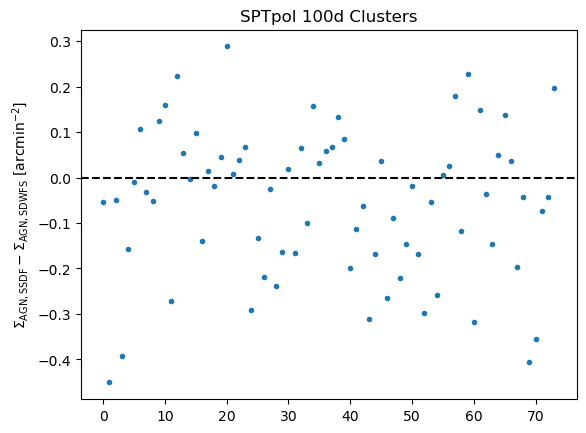

In [9]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sptpol_100d)), (sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2), marker='.')
ax.axhline(y=0., ls='--', color='k')
ax.set(title='SPTpol 100d Clusters', ylabel=r'$\Sigma_{\rm AGN, SSDF} - \Sigma_{\rm AGN, SDWFS}$ [arcmin$^{-2}$]')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/cluster_agn_surf_den/local_bkg_surf_den_SSDF_check_updatedSDWFS-WISE_fixedcols.pdf')